## No Deeplearning

In [1]:
import pandas as pd
import numpy as np
from numpy import mean
#visualizations
import matplotlib.pyplot as plt
%matplotlib inline
#text preprocessing libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TweetTokenizer
#regular expressions
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [2]:
#dataset จาก https://www.kaggle.com/prakharprasad/twitter-hate-speech
dataset = pd.read_csv("TwitterHate.csv")
dataset.head()
df = pd.DataFrame(dataset)
print(df)

       label                                              tweet
0          0   @user when a father is dysfunctional and is s...
1          0  @user @user thanks for #lyft credit i can't us...
2          0                                bihday your majesty
3          0  #model   i love u take with u all the time in ...
4          0             factsguide: society now    #motivation
...      ...                                                ...
31957      0  ate @user isz that youuu?ðððððð...
31958      0    to see nina turner on the airwaves trying to...
31959      0  listening to sad songs on a monday morning otw...
31960      1  @user #sikh #temple vandalised in in #calgary,...
31961      0                   thank you @user for you follow  

[31962 rows x 2 columns]


In [3]:
df[:10]

,label,tweet
0,0,@user when a father is dysfunctional and is s...
1,0,@user @user thanks for #lyft credit i can't us...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ...
4,0,factsguide: society now #motivation
5,0,[2/2] huge fan fare and big talking before the...
6,0,@user camping tomorrow @user @user @user @use...
7,0,the next school year is the year for exams.ð...
8,0,we won!!! love the land!!! #allin #cavs #champ...
9,0,@user @user welcome here ! i'm it's so #gr...


#### ลบตัวอักษรพิเศษ เช่น ð 

In [4]:
def simplify(text):
    '''Function to handle the diacritics in the text'''
    import unicodedata
    try:
        text = unicode(text, 'utf-8')
    except NameError:
        pass
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    return str(text)

In [5]:
df['tweet'] = df['tweet'].apply(simplify)
print(df[:10])

   label                                              tweet
0      0   @user when a father is dysfunctional and is s...
1      0  @user @user thanks for #lyft credit i can't us...
2      0                                bihday your majesty
3      0  #model   i love u take with u all the time in ...
4      0             factsguide: society now    #motivation
5      0  [2/2] huge fan fare and big talking before the...
6      0   @user camping tomorrow @user @user @user @use...
7      0  the next school year is the year for exams. ca...
8      0  we won!!! love the land!!! #allin #cavs #champ...
9      0   @user @user welcome here !  i'm   it's so #gr...


#### ลบ @ 

In [6]:
#test on a sample string
df['tweet'].replace(r'@\w+','',regex=True,inplace=True)
print(df[:10])

   label                                              tweet
0      0    when a father is dysfunctional and is so sel...
1      0    thanks for #lyft credit i can't use cause th...
2      0                                bihday your majesty
3      0  #model   i love u take with u all the time in ...
4      0             factsguide: society now    #motivation
5      0  [2/2] huge fan fare and big talking before the...
6      0                     camping tomorrow        dannya
7      0  the next school year is the year for exams. ca...
8      0  we won!!! love the land!!! #allin #cavs #champ...
9      0              welcome here !  i'm   it's so #gr8 ! 


#### ลบ URL

In [7]:
#remove all URLs
sample = "get more info from https://www.machinelearing.com prakhar and https://www.simple.com"
pattern = re.compile(r'http\S+')
print(re.findall(pattern,sample))
df['tweet'].replace(r'http\S+','',regex=True,inplace=True)
print(df[:10])

['https://www.machinelearing.com', 'https://www.simple.com']
   label                                              tweet
0      0    when a father is dysfunctional and is so sel...
1      0    thanks for #lyft credit i can't use cause th...
2      0                                bihday your majesty
3      0  #model   i love u take with u all the time in ...
4      0             factsguide: society now    #motivation
5      0  [2/2] huge fan fare and big talking before the...
6      0                     camping tomorrow        dannya
7      0  the next school year is the year for exams. ca...
8      0  we won!!! love the land!!! #allin #cavs #champ...
9      0              welcome here !  i'm   it's so #gr8 ! 


#### แบ่งคำ

In [8]:
#test on a sample text
sample = 'wonderfl :-)  when are you coming for #party'
tweet_tokenize = TweetTokenizer(preserve_case=True)
print(tweet_tokenize.tokenize(sample))

['wonderfl', ':-)', 'when', 'are', 'you', 'coming', 'for', '#party']


In [9]:
#tokenize the tweets in the dataframe using TweetTokenizer
tokenizer = TweetTokenizer(preserve_case=True)
df['tweet'] = df['tweet'].apply(tokenizer.tokenize)

In [10]:
print(df[:10])

   label                                              tweet
0      0  [when, a, father, is, dysfunctional, and, is, ...
1      0  [thanks, for, #lyft, credit, i, can't, use, ca...
2      0                            [bihday, your, majesty]
3      0  [#model, i, love, u, take, with, u, all, the, ...
4      0         [factsguide, :, society, now, #motivation]
5      0  [[, 2/2, ], huge, fan, fare, and, big, talking...
6      0                        [camping, tomorrow, dannya]
7      0  [the, next, school, year, is, the, year, for, ...
8      0  [we, won, !, !, !, love, the, land, !, !, !, #...
9      0         [welcome, here, !, i'm, it's, so, #gr8, !]


#### เพิ่มคำลงใน list ของ stopword และลบออกจาก tweet

In [11]:
stop_words = stopwords.words('english')

#add additional stop words to be removed from the text
additional_list = ['amp','rt','u',"can't",'ur']
for words in additional_list:
    stop_words.append(words)
def remove_stopwords(text):
    '''Function to remove the stop words from the text corpus'''
    clean_text = [word for word in text if not word in stop_words]
    return clean_text  
#remove the stop words from the tweets
df['tweet'] = df['tweet'].apply(remove_stopwords)

In [12]:
#remove stop words
def remove_stopwords(text):
    '''Function to remove the stop words from the text corpus'''
    clean_text = [word for word in text if not word in stop_words]
    return clean_text  
#remove the stop words from the tweets
df['tweet'] = df['tweet'].apply(remove_stopwords)

In [13]:
print(df[:10])

   label                                              tweet
0      0  [father, dysfunctional, selfish, drags, kids, ...
1      0  [thanks, #lyft, credit, use, cause, offer, whe...
2      0                                  [bihday, majesty]
3      0                [#model, love, take, time, !, !, !]
4      0              [factsguide, :, society, #motivation]
5      0  [[, 2/2, ], huge, fan, fare, big, talking, lea...
6      0                        [camping, tomorrow, dannya]
7      0  [next, school, year, year, exams, ., think, #s...
8      0  [!, !, !, love, land, !, !, !, #allin, #cavs, ...
9      0                         [welcome, !, i'm, #gr8, !]


#### ลบ '#'

In [14]:
#try tremoving # symbols from a sample text
def remove_hashsymbols(text):
    '''Function to remove the hashtag symbol from the text'''
    pattern = re.compile(r'#')
    text = ' '.join(text)
    clean_text = re.sub(pattern,'',text)
    return tokenizer.tokenize(clean_text)

In [15]:
df['tweet'] = df['tweet'].apply(remove_hashsymbols)
print(df[:10])

   label                                              tweet
0      0  [father, dysfunctional, selfish, drags, kids, ...
1      0  [thanks, lyft, credit, use, cause, offer, whee...
2      0                                  [bihday, majesty]
3      0                 [model, love, take, time, !, !, !]
4      0               [factsguide, :, society, motivation]
5      0  [[, 2/2, ], huge, fan, fare, big, talking, lea...
6      0                        [camping, tomorrow, dannya]
7      0  [next, school, year, year, exams, ., think, sc...
8      0  [!, !, !, love, land, !, !, !, allin, cavs, ch...
9      0                          [welcome, !, i'm, gr8, !]


#### ลบคำสั้น และคืนค่าเป็น String

In [16]:
def rem_shortwords(text):
    '''Function to remove the short words of length 1 and 2 characters'''
    '''Arguments: 
       text: string
       returns: string without containing words of length 1 and 2'''
    lengths = [1,2]
    new_text = ' '.join(text)
    for word in text:
        text = [word for word in tokenizer.tokenize(new_text) if not len(word) in lengths]        
    return new_text 

In [17]:
df['tweet'] = df['tweet'].apply(rem_shortwords)
print(df[:10])

   label                                              tweet
0      0  father dysfunctional selfish drags kids dysfun...
1      0  thanks lyft credit use cause offer wheelchair ...
2      0                                     bihday majesty
3      0                         model love take time ! ! !
4      0                    factsguide : society motivation
5      0  [ 2/2 ] huge fan fare big talking leave . chao...
6      0                            camping tomorrow dannya
7      0  next school year year exams . think school exa...
8      0  ! ! ! love land ! ! ! allin cavs champions cle...
9      0                                welcome ! i'm gr8 !


#### แบ่ง dataset ที่จะ train และ test

In [18]:
from sklearn.model_selection import train_test_split
msg_train,msg_test,label_train,label_test = train_test_split(df['tweet'],df['label'],test_size=0.2)

In [19]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
   ( 'bow',CountVectorizer()),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB()),
])

In [20]:
#จับเวลา
import time
start_time = time.time()

#Cross Validation accuracy scores 
scores = cross_val_score(pipeline, X=msg_train, y=label_train, cv=10, n_jobs=1)
print('Cross Validation accuracy scores: %s' % scores,"\n")

#ระยะเวลาที่ run
print("Time: %.2f minutes" % ((time.time() - start_time)*0.016666))

Cross Validation accuracy scores: [0.94172859 0.93586234 0.93977317 0.93664451 0.93703559 0.93820884
 0.94016425 0.93820884 0.94172859 0.93935837] 

Time: 0.05 minutes


In [21]:
print('avg accuracy : %.2f' % (mean(scores)*100),"%")

avg accuracy : 93.89 %


In [22]:
pipeline.fit(msg_train,label_train)

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [23]:
predictions = pipeline.predict(msg_test)

In [24]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(predictions,label_test))
conf = confusion_matrix(predictions,label_test)
print('')
print('                   Not-Hate  Hate')
print('')
print('Actual Not-Hate    %6d' %conf[0,0] + '   %5d' %conf[0,1])
print('Actual Hate        %6d' %conf[1,0] + '   %5d' %conf[1,1])

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      6324
           1       0.17      1.00      0.29        69

    accuracy                           0.95      6393
   macro avg       0.59      0.97      0.63      6393
weighted avg       0.99      0.95      0.97      6393


                   Not-Hate  Hate

Actual Not-Hate      5991     333
Actual Hate             0      69


In [25]:
def predict_tweet(text):
    remove_stopwords(text)
    predictions = pipeline.predict(text)
    if(predictions == 1):
        return "Hate Speech"
    else:
        return "Not-Hate Speech"

In [26]:
example_tweet = ["hispanic & feel like they stomping"]
print("hispanic & feel like they stomping = ",predict_tweet(example_tweet))
#his panic & feel like they stomping?

example_tweet2 = ["camping tomorrow!"]
print("camping tomorrow! = ",predict_tweet(example_tweet2))

hispanic & feel like they stomping =  Hate Speech
camping tomorrow! =  Not-Hate Speech


## Deeplearning แบบที่ 1

In [75]:
from sklearn.model_selection import train_test_split

sentences = df['tweet'].values
y = df['label'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.2, random_state=1000)
print("Length of Train:",len(sentences_train))
print("Length of Test:",len(sentences_test))

Length of Train: 25569
Length of Test: 6393


In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

<b>แปลงตัวหนังสือเป็นตัวเลข

In [77]:
from sklearn.feature_extraction.text import CountVectorizer

## สร้างคำศัพท์ที่ใช้เป็น feature จากข้อมูล train
vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
print(len(vectorizer.vocabulary_))
print(vectorizer.vocabulary_) 

## สร้าง feature vector หรือ Bag-of-word(BOW) feature 
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

35491
{'happy': 14436, 'shopping': 28317, 'jacobtian': 16862, 'lingsjourney': 18708, 'instalike': 16376, 'instakids': 16373, 'smile': 28851, '1year3monthsa': 347, 'wait': 33669, 'fly': 12184, 'first': 11938, 'time': 31707, 'going': 13538, 'sta': 29562, 'newaddiction': 21873, 'ai': 1748, 'nervous': 21816, 'people': 23916, 'take': 30715, 'blame': 4622, 'anything': 2552, 'make': 19588, 'feel': 11618, 'like': 18628, 'one': 22925, 'wrong': 34926, 'fuckoff': 12713, 'extract': 11187, 'emails': 10481, 'website': 33975, 'v178': 33142, 'clothing': 7050, 'lukehemmings': 19350, 'vscogood': 33619, 'friday': 12581, 'loversai': 19221, 'love': 19105, 'king': 17718, 'queen': 25575, 'trust': 32410, 'suppo': 30377, 'bff': 4266, 'show': 28349, 'added': 1451, 'traditional': 32098, 'pre': 24919, 'gig': 13295, 'pint': 24298, 'premier': 24956, 'inn': 16237, 'coldplaywembley': 7185, 'beach': 3782, 'makes': 19612, 'hea': 14641, 'afghan': 1614, 'forces': 12323, 'opened': 23054, 'firing': 11935, 'near': 21708, 't

In [78]:
input_dim = X_train.shape[1]  
print(input_dim)

model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

35491


In [79]:
model.compile(loss='binary_crossentropy', optimizer="SGD", metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                354920    
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 354,931
Trainable params: 354,931
Non-trainable params: 0
_________________________________________________________________


In [80]:
# ถ้าเคย train model ด้วย model.fit แล้วต้องการรันใหม่อีกครั้งให้เคลียร์ค่า weight เก่าก่อน 
# ถ้าไม่เคลียร์ค่า weight เก่า จะทำการ train ต่อจากครั้งล่าสุด
from tensorflow.keras.backend import clear_session
clear_session()

In [81]:
import time
start_time = time.time()
history = model.fit(X_train, y_train,epochs=30,verbose=1,validation_data=(X_test, y_test),batch_size=10)
print("Time: %.2f minutes" % ((time.time() - start_time)*0.016666))

Epoch 1/30


C:\Users\Gisgus\anaconda3\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Reshape:0", shape=(None, 10), dtype=float32), dense_shape=Tensor("gradient_tape/sequential/dense/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


2557/2557 [==============================] - 3s 997us/step - loss: 0.2786 - accuracy: 0.9285 - val_loss: 0.2382 - val_accuracy: 0.9304
Epoch 2/30
2557/2557 [==============================] - 3s 1000us/step - loss: 0.2281 - accuracy: 0.9297 - val_loss: 0.2178 - val_accuracy: 0.9304
Epoch 3/30
2557/2557 [==============================] - 3s 996us/step - loss: 0.2041 - accuracy: 0.9307 - val_loss: 0.1962 - val_accuracy: 0.9345
Epoch 4/30
2557/2557 [==============================] - 3s 1ms/step - loss: 0.1808 - accuracy: 0.9365 - val_loss: 0.1770 - val_accuracy: 0.9388
Epoch 5/30
2557/2557 [==============================] - 3s 1ms/step - loss: 0.1610 - accuracy: 0.9426 - val_loss: 0.1625 - val_accuracy: 0.9417
Epoch 6/30
2557/2557 [==============================] - 3s 970us/step - loss: 0.1453 - accuracy: 0.9474 - val_loss: 0.1518 - val_accuracy: 0.9456
Epoch 7/30
2557/2557 [==============================] - 2s 943us/step - loss: 0.1327 - accuracy: 0.9511 - val_loss: 0.1436 - val_accuracy:

In [82]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Loss: {:.4f}".format(loss))
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Loss: {:.4f}".format(loss))
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Loss: 0.0315
Training Accuracy: 0.9924

Testing Loss: 0.1088
Testing Accuracy:  0.9642


In [83]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

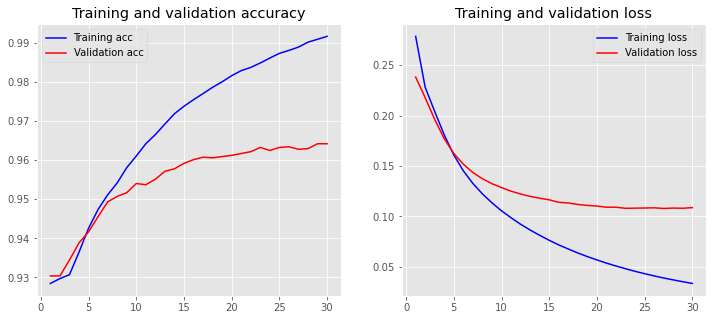

In [84]:
plot_history(history)

In [87]:
text = ["Lviv mayor says city is struggling to feed and house 200,000 displaced Ukrainians"]
#เปลี่ยนคำเป็นตัวเลข
tweet = vectorizer.transform(text) 
tweet_predict = (model.predict(tweet))
if np.argmax(tweet_predict)==0: 
    print (text,": Not-Hate")
else:
    print (text,": Hate")

['Lviv mayor says city is struggling to feed and house 200,000 displaced Ukrainians'] : Not-Hate
